<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [194]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="../data/KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="../data/KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [177]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**
Чем больше `batch_size`, тем быстрее модель учится. Получается с увеличением размера бача усреднение градиентов будет происходить по выборке данных более приближенному ко всему набору

Посмотрим на какую-нибудь картинку:

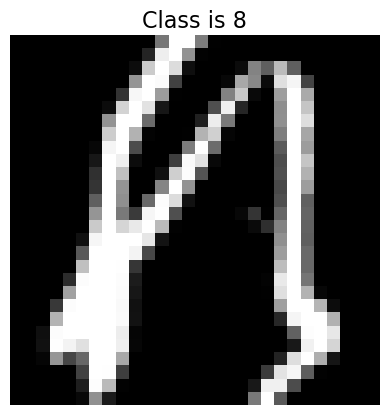

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [15]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [69]:
images.view(-1, 28*28).shape

torch.Size([96, 784])

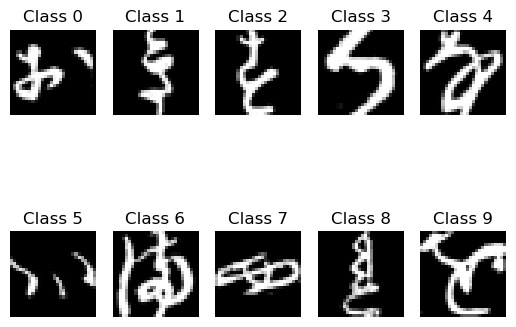

In [66]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    image = images[labels == i][0].squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [55]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

self.fc1:      
Веса: 28 * 28 * 256 = 7168       
Смещения: 256      

self.fc2:      
Веса: 256 * 2128 = 545408      
Смещения: 2128       
Всего: 547536      

self.fc3:       
Веса: 2128 * 10 = 21280      
Смещения: 10       
Всего: 21290     

**Общее количество параметров:** 579250 


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [56]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [57]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [59]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


In [60]:
get_accuracy(fc_net, testloader)

0.9042

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [95]:
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for images, labels in trainloader:
    psum += images.sum(axis=[0,2,3])
    psum_sq += (images**2).sum(axis=[0,2,3])

count = len(trainset) * 28 * 28

In [111]:
mean = psum[0] / count
std = torch.sqrt(psum_sq[0] / count - mean ** 2)
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [112]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [113]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))



In [114]:
get_accuracy(fc_net, testloader)

0.9058

Как изменилась `accuracy` после нормализации?

Увеличилась на 0.006

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

### Sigmoid

In [115]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        logits = self.fc3(x)
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        return logits

In [116]:
%%time
n_epochs = 10
loss_history = []

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


CPU times: user 3min 31s, sys: 6.11 s, total: 3min 37s
Wall time: 24.4 s


In [117]:
get_accuracy(fc_net, testloader)

0.9115

### GELU

In [118]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        logits = self.fc3(x)
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        return logits

In [119]:
%%time
n_epochs = 10
loss_history = []

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


CPU times: user 3min 32s, sys: 7.48 s, total: 3min 40s
Wall time: 24.7 s


In [120]:
get_accuracy(fc_net, testloader)

0.9119

### Tanh

In [121]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        logits = self.fc3(x)
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        return logits

In [122]:
%%time
n_epochs = 10
loss_history = []

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


CPU times: user 3min 30s, sys: 6.97 s, total: 3min 37s
Wall time: 24.1 s


In [123]:
get_accuracy(fc_net, testloader)

0.9123

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Tanh

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

Adam использовался изначально

### Adagrad

In [186]:
%%time
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


CPU times: user 3min 41s, sys: 10.1 s, total: 3min 51s
Wall time: 25.1 s


In [187]:
get_accuracy(fc_net, testloader)

0.9149

### RMSprop

In [128]:
%%time
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


CPU times: user 3min 48s, sys: 7.47 s, total: 3min 56s
Wall time: 26.7 s


In [129]:
get_accuracy(fc_net, testloader)

0.8993

Наилучшие результаты показал Adagrad

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [191]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = torch.max(torch.zeros_like(x), x)
        x = self.fc2(x)
        x = torch.max(torch.zeros_like(x), x)
        logits = self.fc3(x)

        return logits

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [192]:
%%time
cstm_RL = CustomReLU()
optimizer = torch.optim.Adagrad(cstm_RL.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = cstm_RL(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


CPU times: user 3min 42s, sys: 8.39 s, total: 3min 50s
Wall time: 25.4 s


In [193]:
get_accuracy(cstm_RL, testloader)

0.7687

Не понимаю, в чем тут проблема. Accuracy получается меньше. Прошу объяснить при ревью

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

![Изображение №1](../data/image_3.jpg)

![Изображение №2](../data/image_2.jpg)

![Изображение №3](../data/image_1.jpg)

Всё-таки сильно заметна версия